In [1]:
# MISC
import os
import sys

sys.path.append("..")
os.environ['MUJOCO_GL']='egl'
os.environ['CUDA_VISIBLE_DEVICES']='0'

import shutup
shutup.please()

import jax
import jax.numpy as jnp

import numpy as np
from functools import partial

# VIZ
import matplotlib.pyplot as plt
from rich.pretty import pprint
from tqdm.auto import tqdm

from hydra import initialize, compose
from omegaconf import OmegaConf

plt.style.use(['seaborn-v0_8-colorblind', 'seaborn-v0_8-notebook'])
colors = plt.rcParams['axes.prop_cycle'].by_key()['color'] 

GLOBAL_KEY = jax.random.key(42)

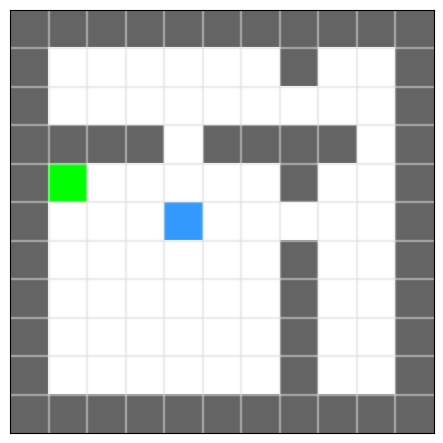

In [2]:
from envs.custom_mazes.darkroom import FourRoomsMazeEnv, Maze

test = FourRoomsMazeEnv(Maze(seed=0, maze_type='fourrooms_random_layouts'))
test.reset()
test.render(return_img=False) 

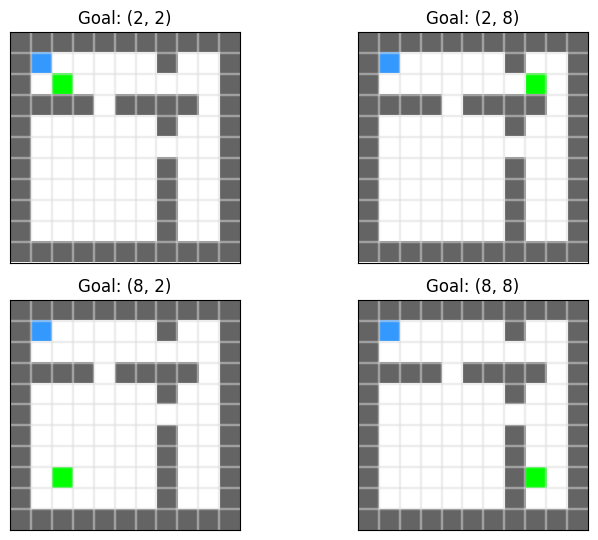

In [3]:
fig, ax = plt.subplots(nrows=2, ncols=2)
for i, cur_ax in enumerate(ax.flat, start=1):
    test.setup_goals(seed=None, task_num=i, start_pos=(1, 1))
    test.render(ax=cur_ax)
    cur_ax.set_title(f"Goal: {test.goal}")
plt.tight_layout()

In [4]:
from envs.custom_mazes.darkroom import FourRoomsMazeEnv, Maze

test = FourRoomsMazeEnv(Maze(seed=0))
test.reset()
img = test.render(return_img=True) 

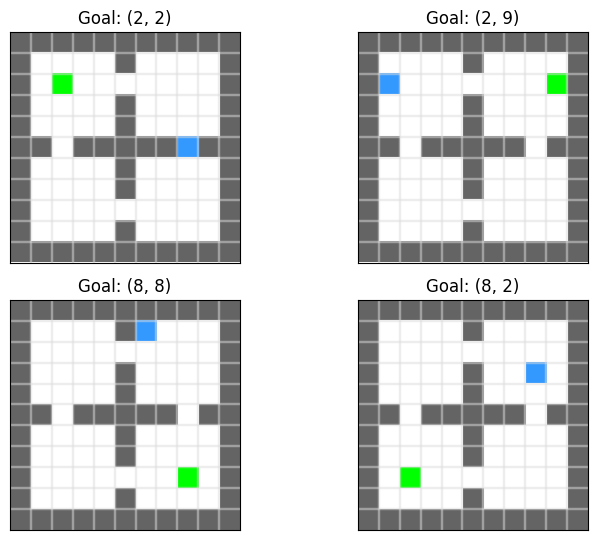

In [5]:
fig, ax = plt.subplots(nrows=2, ncols=2)
for i, cur_ax in enumerate(ax.flat, start=1):
    test.setup_goals(seed=None, task_num=i)
    test.render(ax=cur_ax)
    cur_ax.set_title(f"Goal: {test.goal}")
plt.tight_layout()

# Data Collection

Set `NUM_TRAIN_LAYOUTS` to 1 argument in `FourRoomsMazeEnv` in order to train usual FB on single instance of Fourrooms. 

Set `NUM_TRAIN_LAYOUTS > 1` to generate different maze layouts and train FB on this mixed data.

  0%|          | 0/1 [00:00<?, ?it/s]

{
│   'actions': (99000,),
│   'layout_type': (99000, 1),
│   'next_observations': (99000, 2),
│   'observations': (99000, 2),
│   'terminals': (99000,)
}

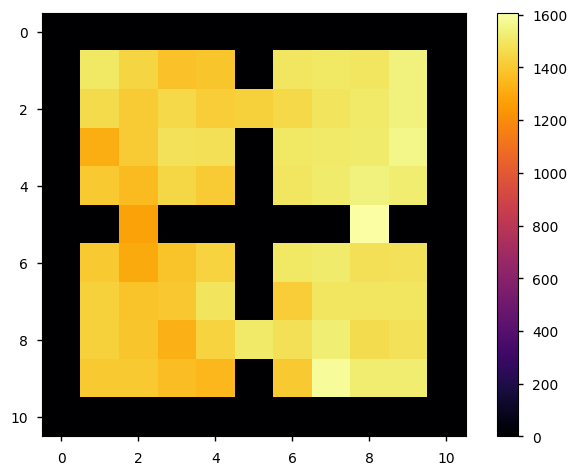

In [6]:
from envs.minigrid.env_utils import random_exploration_fourrooms, q_learning

train_layout_data = []

NUM_TRAIN_LAYOUTS = 1
NUM_TRAIN_STEPS = 99
NUM_TRAIN_EPISODES = 1000
seeds = np.arange(0, NUM_TRAIN_LAYOUTS)

if NUM_TRAIN_LAYOUTS > 1:
    for i in tqdm(range(NUM_TRAIN_LAYOUTS)):
        env = FourRoomsMazeEnv(Maze(seed=seeds[i], maze_type='fourrooms_random_layouts'), max_steps=NUM_TRAIN_STEPS)
        dataset, env = random_exploration_fourrooms(env, num_episodes=NUM_TRAIN_EPISODES, layout_type=i, num_mdp=NUM_TRAIN_LAYOUTS)
        train_layout_data.append(dataset)
else:
    for i in tqdm(range(1)):
        env = FourRoomsMazeEnv(Maze(seed=seeds[i]), max_steps=NUM_TRAIN_STEPS)
        dataset, env = random_exploration_fourrooms(env, num_episodes=NUM_TRAIN_EPISODES, layout_type=i, num_mdp=NUM_TRAIN_LAYOUTS)
        train_layout_data.append(dataset)
        
pprint(jax.tree.map(lambda x: x.shape, train_layout_data[0]))

coverage_map = np.zeros(shape=env.maze.size)
for layout in train_layout_data:
    for obs in layout['observations']:
        obs = obs.astype(np.int16)
        coverage_map[obs[1], obs[0]] += 1
        
plt.imshow(coverage_map, cmap='inferno', vmin=0)
plt.colorbar()
plt.show()

In [ ]:
import functools
from utils.datasets import Dataset, GCDataset

with initialize(version_base=None, config_path="../configs/"):
    fb_config = compose(config_name='entry.yaml', overrides=['experiment=fb_vanilla_discrete_4rooms.yaml',
                                                            f'agent.z_dim=150',
                                                            f'agent.z_mix_ratio=0.5']) # test
    fb_config = OmegaConf.to_container(fb_config, resolve=True)
    pprint(fb_config)

def concatenate_dicts(dict1, dict2):
    return jax.tree.map(lambda x, y: jnp.concatenate([x, y]), dict1, dict2)

whole_data = functools.reduce(concatenate_dicts, train_layout_data)
# Saving
# np.save(f"../aux_data/fourroom_vanilla_data", arr=jax.device_get(whole_data))
# whole_data = np.load("/home/m_bobrin/ZeroShotRL/aux_data/fourroom_vanilla_data.npy", allow_pickle=True).item()

print(jax.tree.map(lambda x: x.shape, whole_data))
whole_dataset = Dataset.create(**jax.device_get(whole_data))
gc_whole_dataset = GCDataset(whole_dataset, config=fb_config['agent'])

{
│   'seed': 42,
│   'run_group': 'fb',
│   'save_dir': 'experiment_logs/',
│   'train_steps': 150000,
│   'log_interval': 10000,
│   'eval_interval': 30000,
│   'eval_tasks': None,
│   'eval_episodes': 20,
│   'eval_temperature': 0,
│   'eval_gaussian': None,
│   'video_episodes': 1,
│   'video_frame_skip': 3,
│   'eval_on_cpu': 0,
│   'frame_stack': None,
│   'p_aug': None,
│   'agent': {
│   │   'agent_name': 'fb',
│   │   'lr': 0.0003,
│   │   'batch_size': 1024,
│   │   'discrete': True,
│   │   'discount': 0.99,
│   │   'tau': 0.01,
│   │   'clip_by_global_norm': True,
│   │   'dataset_class': 'GCDataset',
│   │   'value_p_curgoal': 0.0,
│   │   'value_p_trajgoal': 1.0,
│   │   'value_p_randomgoal': 0.0,
│   │   'value_geom_sample': True,
│   │   'actor_p_curgoal': 0.0,
│   │   'actor_p_trajgoal': 0.0,
│   │   'actor_p_randomgoal': 1.0,
│   │   'actor_geom_sample': False,
│   │   'gc_negative': True,
│   │   'p_aug': 0.0,
│   │   'frame_stack': None,
│   │   'z_dim': 150,
│   │   'z_mix_ratio': 0.5,
│   │   'boltzmann': True,
│   │   'f_hidden_dims': [1024, 512, 512],
│   │   'f_layer_norm': True,
│   │   'b_hidden_dims': [512, 512, 512],
│   │   'b_layer_norm': True,
│   │   'use_context': False
│   },
│   'env': {'env_name': 'fourrooms-vanilla', 'discrete': True},
│   'tags': ['vanilla-fb', '4rooms', 'discrete']
}

{'actions': (990000,), 'layout_type': (990000, 10), 'next_observations': (990000, 2), 'observations': (990000, 2), 'terminals': (990000,)}


In [8]:
sys.path.append("..")
from agents.fb import ForwardBackwardAgent

gc_whole_dataset = GCDataset(whole_dataset, config=fb_config['agent'])
example_batch = gc_whole_dataset.sample(1)
fb_agent = ForwardBackwardAgent.create(
    0,
    example_batch['observations'],
    np.full_like(example_batch['actions'], env.action_space.n - 1),
    config=fb_config['agent']
)
fb_agent, info = fb_agent.update(gc_whole_dataset.sample(512))

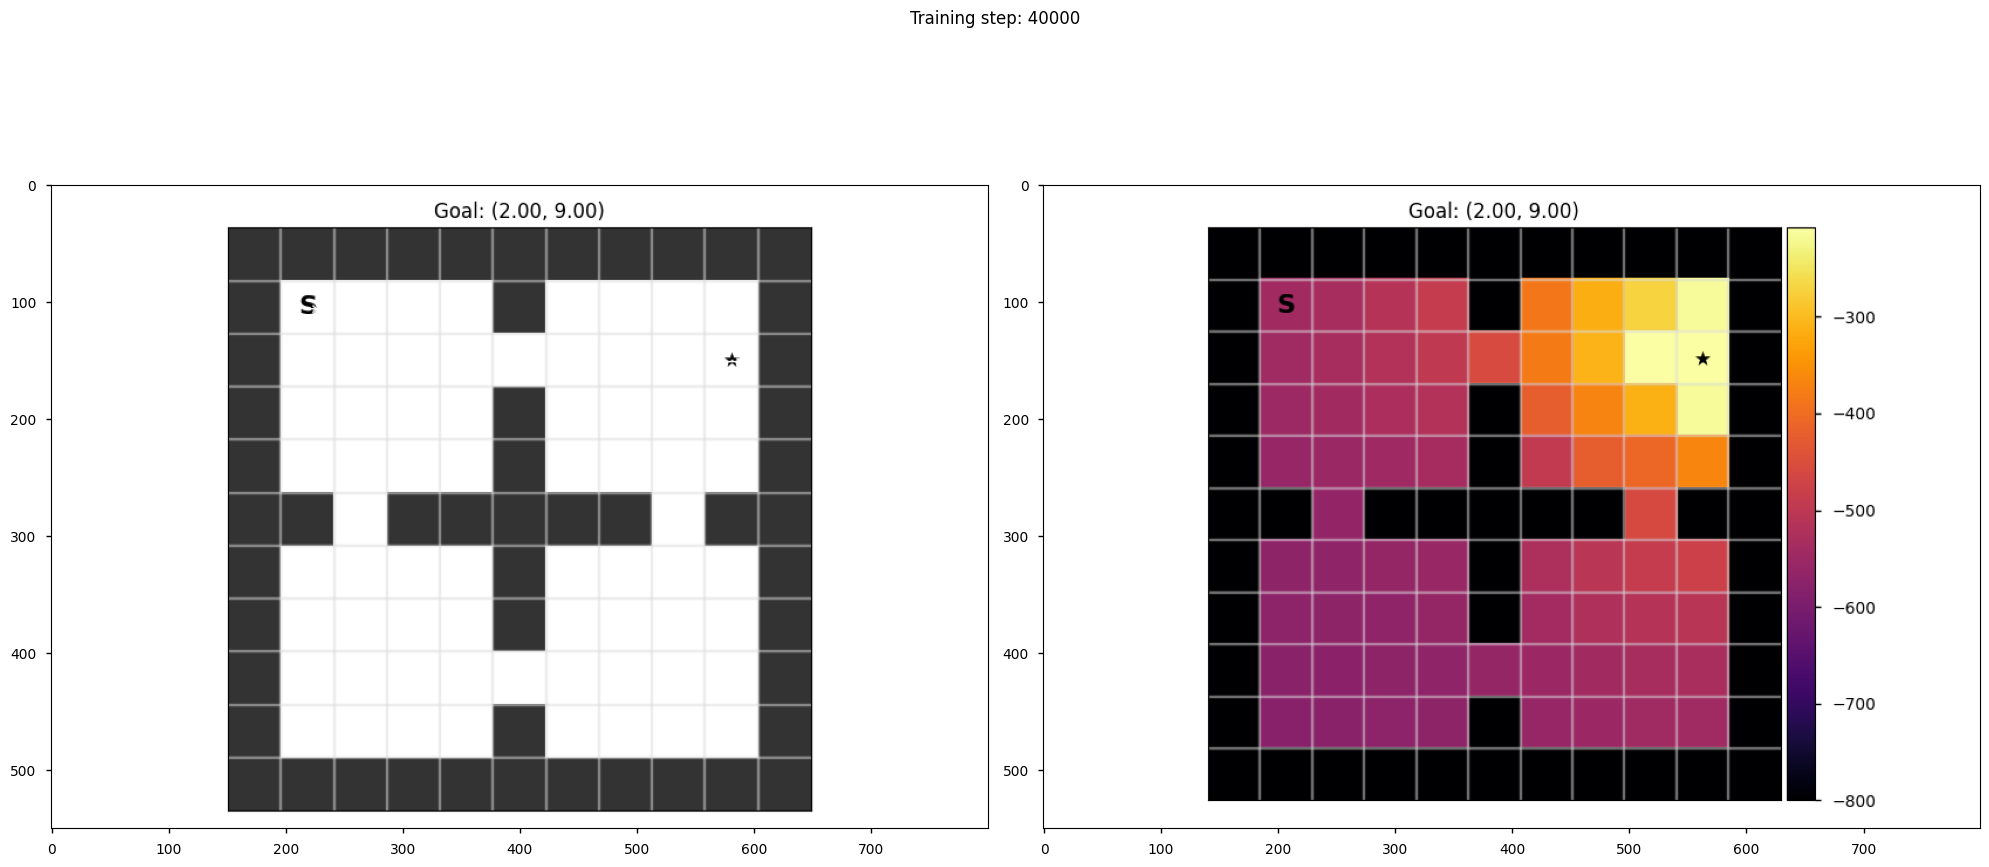

KeyboardInterrupt: 

In [9]:
from envs.custom_mazes.env_utils import policy_image_fourrooms, value_image_fourrooms
from functools import partial
from utils.evaluation import supply_rng
from IPython.display import clear_output
from envs.env_utils import EpisodeMonitor

START_POS = (1,1)
def visualize_value_image(task_num):
    env = FourRoomsMazeEnv(Maze(seed=0))
    env.reset()
    observation, info = env.setup_goals(seed=None, task_num=task_num, start_pos=START_POS)
    goal = info.get("goal_pos", None)
    latent_z = jax.device_get(fb_agent.infer_z(goal)[None])
    N, M = env.maze.size
    pred_value_img = value_image_fourrooms(env, example_batch, N=N, M=M,
                                value_fn=partial(fb_agent.predict_q, z=latent_z), goal=goal)
    return pred_value_img

def visualize_policy(task_num):
    env = FourRoomsMazeEnv(Maze(seed=0))
    env.reset()
    observation, info = env.setup_goals(seed=None, task_num=task_num, start_pos=START_POS)
    goal = info.get("goal_pos", None)
    latent_z = fb_agent.infer_z(goal)
    start = info.get("start_pos", None)
    example_batch = whole_dataset.sample(1)
    pred_policy_img = policy_image_fourrooms(env, example_batch, N=env.maze.size[0], M=env.maze.size[1],
                                                    action_fn=partial(supply_rng(fb_agent.sample_actions, rng=jax.random.PRNGKey(np.random.randint(0, 2**32))), latent_z=latent_z, temperature=0.0),
                                                    goal=goal, start=start)
    return pred_policy_img

pbar = tqdm(range(200_001))
env = FourRoomsMazeEnv(Maze(seed=0), max_steps=NUM_TRAIN_STEPS)
q = EpisodeMonitor(env, filter_regexes=['.*privileged.*', '.*proprio.*'])

for update_step in pbar:
    batch = gc_whole_dataset.sample(1024)
    fb_agent, info = fb_agent.update(batch)
    
    if update_step % 20_000 == 0:
        clear_output()
        fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(20, 10))
        pred_policy_img = visualize_policy(task_num=2)
        ax[0].imshow(pred_policy_img)
        pred_value_img = visualize_value_image(task_num=2)
        ax[1].imshow(pred_value_img)
        
        fig.suptitle(f"Training step: {update_step}")   
        plt.tight_layout()
        display(fig)
        plt.close(fig)

In [ ]:
from utils.evaluation import add_to, flatten, supply_rng
from collections import defaultdict
import numpy as np
from tqdm import trange

START_POS = (1, 1)
def evaluate_fourrooms(
    agent,
    env,
    task_id=None,
    config=None,
    num_eval_episodes=10,
    num_video_episodes=0,
    video_frame_skip=3,
    eval_temperature=0.0,
    eval_gaussian=None,
):

    actor_fn = supply_rng(agent.sample_actions, rng=jax.random.PRNGKey(np.random.randint(0, 2**32)))
    trajs = []
    stats = defaultdict(list)
    pbar = range(num_eval_episodes + num_video_episodes)
    renders = []
    for i in pbar:
        traj = defaultdict(list)
        should_render = i >= num_eval_episodes
        observation, info = env.unwrapped.setup_goals(seed=None, task_num=task_id, start_pos=START_POS)
        goal = info.get("goal_pos", None)
        done = False
        step = 0
        render = []
        latent_z = agent.infer_z(goal)

        while not done:
            action = actor_fn(observations=observation, latent_z=latent_z, temperature=eval_temperature)
            next_observation, reward, terminated, truncated, info = env.step(jax.device_get(action.squeeze()))
            done = terminated or truncated
            step += 1

            if should_render and (step % video_frame_skip == 0 or done):
                # frame = env.unwrapped.render(return_img=True).copy()
                render.append(env.unwrapped.render(return_img=True).copy())

            transition = dict(
                observation=observation,
                next_observation=next_observation,
                action=action,
                reward=reward,
                done=done,
                info=info,
            )
            add_to(traj, transition)
            observation = next_observation
        if i < num_eval_episodes:
            add_to(stats, flatten(info))
            trajs.append(traj)
        else:
            renders.append(np.array(render))

    for k, v in stats.items():
        stats[k] = np.mean(v)

    return stats, trajs, renders

from envs.env_utils import EpisodeMonitor
eval_metrics = {}
overall_metrics = defaultdict(list)
eval_history_train = []
eval_history_test = []
for task_id in range(2, 5): # static for 4 rooms
    for env_id in range(NUM_TRAIN_LAYOUTS):
        env = FourRoomsMazeEnv(Maze(seed=env_id, maze_type='fourrooms_random_layouts'), NUM_TRAIN_STEPS)
        env = EpisodeMonitor(env, filter_regexes=['.*privileged.*', '.*proprio.*'])
        # env.reset(options={"start": (1, 1)})
        eval_info, _, _ = evaluate_fourrooms(
                agent=fb_agent,
                env=env,
                task_id=task_id,
                config=None,
                num_eval_episodes=20,
                num_video_episodes=0,
                video_frame_skip=1,
                eval_temperature=0.0,
                eval_gaussian=None
            )
        eval_metrics.update(
            {f'evaluation/task_{task_id}_{k}': v for k, v in eval_info.items() if k != 'total.timesteps'}
        )
        for k, v in eval_info.items():
            overall_metrics[k].append(v)
            
for k, v in overall_metrics.items():
    eval_metrics[f'evaluation/overall_{k}_train'] = np.mean(v)
    
eval_history_train.append(eval_metrics['evaluation/overall_episode.final_reward_train'])

eval_metrics = {}
overall_metrics = defaultdict(list)
            
for task_id in range(2, 5):
    for env_id in range(NUM_TRAIN_LAYOUTS+50, NUM_TRAIN_LAYOUTS + 60):
        env = FourRoomsMazeEnv(Maze(seed=env_id, maze_type='fourrooms_random_layouts'), max_steps=NUM_TRAIN_STEPS)
        env = EpisodeMonitor(env, filter_regexes=['.*privileged.*', '.*proprio.*'])
        # env.reset(options={"start": (1, 1)})
        eval_info, _, _ = evaluate_fourrooms(
                agent=fb_agent,
                env=env,
                task_id=task_id,
                config=None,
                num_eval_episodes=20, ##
                num_video_episodes=0,
                video_frame_skip=1,
                eval_temperature=0.0,
                eval_gaussian=None
            )
        eval_metrics.update(
            {f'evaluation/task_{task_id}_{k}': v for k, v in eval_info.items() if k != 'total.timesteps'}
            )
        for k, v in eval_info.items():
            overall_metrics[k].append(v)
            
for k, v in overall_metrics.items():
    eval_metrics[f'evaluation/overall_{k}_ood'] = np.mean(v)
eval_history_test.append(eval_metrics['evaluation/overall_episode.final_reward_ood'])

In [ ]:
# RANDOM
def evaluate_fourrooms(
    env,
    task_id=None,
    config=None,
    num_eval_episodes=10,
    num_video_episodes=0,
    video_frame_skip=3,
    eval_temperature=0.0,
    eval_gaussian=None,
):
    """Evaluate the agent in the environment.

    Args:
        agent: Agent.
        env: Environment.
        task_id: Task ID to be passed to the environment.
        config: Configuration dictionary.
        num_eval_episodes: Number of episodes to evaluate the agent.
        num_video_episodes: Number of episodes to render. These episodes are not included in the statistics.
        video_frame_skip: Number of frames to skip between renders.
        eval_temperature: Action sampling temperature.
        eval_gaussian: Standard deviation of the Gaussian noise to add to the actions.

    Returns:
        A tuple containing the statistics, trajectories, and rendered videos.
    """
    # actor_fn = supply_rng(agent.sample_actions, rng=jax.random.PRNGKey(np.random.randint(0, 2**32)))
    trajs = []
    stats = defaultdict(list)
    pbar = trange(num_eval_episodes + num_video_episodes, leave=False, colour='red', position=2)
    renders = []
    for i in pbar:
        traj = defaultdict(list)
        should_render = i >= num_eval_episodes
        observation, info = env.unwrapped.setup_goals(seed=None, task_num=task_id, start_pos=START_POS)
        goal = info.get("goal_pos", None)
        done = False
        step = 0
        render = []
        while not done:
            action = env.action_space.sample()#actor_fn(observations=observation, latent_z=latent_z, temperature=eval_temperature)
            next_observation, reward, terminated, truncated, info = env.step(jax.device_get(action.squeeze()))
            done = terminated or truncated
            step += 1

            if should_render and (step % video_frame_skip == 0 or done):
                frame = env.unwrapped.render(return_img=True).copy()
                render.append(frame)

            transition = dict(
                observation=observation,
                next_observation=next_observation,
                action=action,
                reward=reward,
                done=done,
                info=info,
            )
            add_to(traj, transition)
            observation = next_observation
        if i < num_eval_episodes:
            add_to(stats, flatten(info))
            trajs.append(traj)
        else:
            renders.append(np.array(render))

    for k, v in stats.items():
        stats[k] = np.mean(v)

    return stats, trajs, renders

eval_metrics = {}
overall_metrics = defaultdict(list)
eval_history_train = []
eval_history_test = []
for task_id in range(2, 5): # static for 4 rooms
    for env_id in range(NUM_TRAIN_LAYOUTS):
        env = FourRoomsMazeEnv(Maze(seed=env_id, maze_type='fourrooms_random_layouts'), NUM_TRAIN_STEPS)
        env = EpisodeMonitor(env, filter_regexes=['.*privileged.*', '.*proprio.*'])
        # env.reset(options={"start": (1, 1)})
        eval_info, _, _ = evaluate_fourrooms(
                env=env,
                task_id=task_id,
                config=None,
                num_eval_episodes=10,
                num_video_episodes=0,
                video_frame_skip=1,
                eval_temperature=0.0,
                eval_gaussian=None
            )
        eval_metrics.update(
            {f'evaluation/task_{task_id}_{k}': v for k, v in eval_info.items() if k != 'total.timesteps'}
        )
        for k, v in eval_info.items():
            overall_metrics[k].append(v)
            
for k, v in overall_metrics.items():
    eval_metrics[f'evaluation/overall_{k}_train'] = np.mean(v)
    
eval_history_train.append(eval_metrics['evaluation/overall_episode.final_reward_train'])

eval_metrics = {}
overall_metrics = defaultdict(list)
            
for task_id in range(2, 5):
    for env_id in range(100, 110):
        env = FourRoomsMazeEnv(Maze(seed=env_id, maze_type='fourrooms_random_layouts'), max_steps=NUM_TRAIN_STEPS)
        env = EpisodeMonitor(env, filter_regexes=['.*privileged.*', '.*proprio.*'])
        # env.reset(options={"start": (1, 1)})
        eval_info, _, _ = evaluate_fourrooms(
                env=env,
                task_id=task_id,
                config=None,
                num_eval_episodes=10, ##
                num_video_episodes=0,
                video_frame_skip=1,
                eval_temperature=0.0,
                eval_gaussian=None
            )
        eval_metrics.update(
            {f'evaluation/task_{task_id}_{k}': v for k, v in eval_info.items() if k != 'total.timesteps'}
            )
        for k, v in eval_info.items():
            overall_metrics[k].append(v)
            
for k, v in overall_metrics.items():
    eval_metrics[f'evaluation/overall_{k}_ood'] = np.mean(v)
eval_history_test.append(eval_metrics['evaluation/overall_episode.final_reward_ood'])

In [43]:
eval_history_train

[np.float64(0.12666666666666665)]

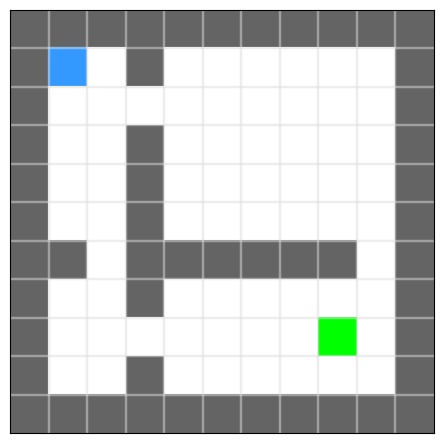

In [41]:
env = FourRoomsMazeEnv(Maze(seed=321213, maze_type='fourrooms_random_layouts'), max_steps=NUM_TRAIN_STEPS)
env = EpisodeMonitor(env, filter_regexes=['.*privileged.*', '.*proprio.*'])

observation, info = env.unwrapped.setup_goals(seed=None, task_num=task_id, start_pos=START_POS)
env.render()

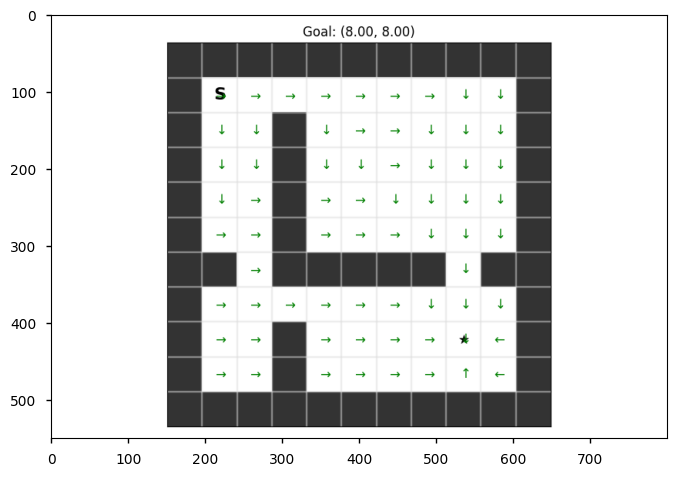

In [ ]:
from envs.custom_mazes.env_utils import plot_policy #policy_image_fourrooms
from functools import partial
from utils.evaluation import supply_rng
import numpy as np

import matplotlib.pyplot as plt
import matplotlib.patches as patches

import shapely
from shapely import Point, GeometryCollection
from matplotlib.backends.backend_agg import FigureCanvasAgg as FigureCanvas
from mpl_toolkits.axes_grid1 import make_axes_locatable
import matplotlib.gridspec as gridspec
from functools import partial
import jax

env = FourRoomsMazeEnv(Maze(seed=228, maze_type='fourrooms_random_layouts', size=11))
env.reset(options={"start": (1, 1)}) # for testing FB on new layout

def get_canvas_image(canvas):
    canvas.draw() 
    # out_image = np.frombuffer(canvas.tostring_rgb(), dtype='uint8')
    # out_image = out_image.reshape(canvas.get_width_height()[::-1] + (3,))
    out_image = np.asarray(canvas.buffer_rgba())
    return out_image

def policy_image_fourrooms(env, dataset, N, M, action_fn=None, **kwargs):
    fig = plt.figure(tight_layout=True)
    canvas = FigureCanvas(fig)
    plot_policy(env, dataset, N, M, fig=fig, ax=plt.gca(), action_fn=action_fn, **kwargs)
    # plt.savefig("fanilla_policy.svg", dpi=300)
    image = get_canvas_image(canvas)
    plt.close(fig)
    return image

observation, info = env.setup_goals(seed=None, task_num=4, start_pos=START_POS)
goal = info.get("goal_pos", None)
latent_z = fb_agent.infer_z(goal)
start = info.get("start_pos", None)
example_batch = whole_dataset.sample(1)
pred_policy_img = policy_image_fourrooms(env, example_batch, N=11, M=11,
                                                action_fn=partial(supply_rng(fb_agent.sample_actions, rng=jax.random.PRNGKey(np.random.randint(0, 2**32))), latent_z=latent_z, temperature=0.0),
                                                goal=goal, start=start)
plt.imshow(pred_policy_img)

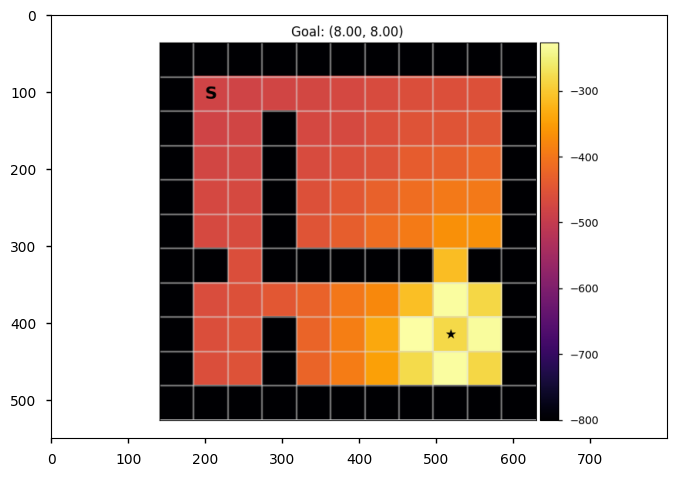

In [ ]:
from envs.custom_mazes.env_utils import plot_value_image_fourrooms, get_canvas_image
from functools import partial
from envs.env_utils import EpisodeMonitor
from envs.custom_mazes.env_utils import plot_policy #policy_image_fourrooms
from functools import partial
from utils.evaluation import supply_rng
import numpy as np

import matplotlib.pyplot as plt
import matplotlib.patches as patches

import shapely
from shapely import Point, GeometryCollection
from matplotlib.backends.backend_agg import FigureCanvasAgg as FigureCanvas
from mpl_toolkits.axes_grid1 import make_axes_locatable
import matplotlib.gridspec as gridspec
from functools import partial
import jax

START_POS = (1,1)

def value_image_fourrooms(env, dataset, value_fn, N, M, action_fn=None, **kwargs):
    """
    Visualize the value function.
    Args:
        env: The environment.
        value_fn: a function with signature value_fn([# states, state_dim]) -> [#states, 1]
    Returns:
        A numpy array of the image.
    """
    fig = plt.figure(tight_layout=True)
    canvas = FigureCanvas(fig)
    plot_value_image_fourrooms(env, dataset, value_fn, N, M, fig=fig, ax=plt.gca(), action_fn=action_fn, **kwargs)
    # plt.savefig("qfunc_vanialla_fb.svg", dpi=300)
    image = get_canvas_image(canvas)
    plt.close(fig)
    return image, plt.gca()

def visualize_value_image(env, task_num):
    observation, info = env.setup_goals(seed=None, task_num=task_num, start_pos=START_POS)
    goal = info.get("goal_pos", None)
    latent_z = jax.device_get(fb_agent.infer_z(goal)[None])
    N, M = env.maze.size
    pred_value_img, ax = value_image_fourrooms(env, example_batch, N=N, M=M,
                                value_fn=partial(fb_agent.predict_q, z=latent_z), goal=goal)
    return pred_value_img, ax

env = FourRoomsMazeEnv(Maze(seed=228, maze_type='fourrooms_random_layouts'), max_steps=NUM_TRAIN_STEPS)
q = EpisodeMonitor(env, filter_regexes=['.*privileged.*', '.*proprio.*'])

observation, info = env.setup_goals(seed=None, task_num=4, start_pos=START_POS)
pred_value_img, ax = visualize_value_image(env, task_num=4)
plt.imshow(pred_value_img)